In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("PyTorch version:", torch.__version__)
print("All libraries imported successfully!")

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0+cu126
All libraries imported successfully!
Using device: cpu


In [3]:
# Load and preprocess the data (same as before)
def load_inflation_data(file_path):
    """Load and reshape the inflation data from Excel format"""
    df = pd.read_excel(file_path, sheet_name='Inflation_Rate')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    data_list = []
    for _, row in df.iterrows():
        year = row['Year']
        for month in months:
            if pd.notna(row[month]):
                data_list.append({
                    'Year': year,
                    'Month': month,
                    'Inflation_Rate': row[month]
                })

    inflation_df = pd.DataFrame(data_list)

    # Replace 'Sept' with 'Sep' to match the expected format for %b
    inflation_df['Month'] = inflation_df['Month'].replace('Sept', 'Sep')

    # Add error handling for year conversion
    def safe_int_conversion(x):
        try:
            return int(x)
        except (ValueError, TypeError) as e:
            print(f"Could not convert year value '{x}' to int: {e}")
            return None # Or some other indicator of failure

    inflation_df['Year'] = inflation_df['Year'].apply(safe_int_conversion)

    # Drop rows where year conversion failed
    inflation_df.dropna(subset=['Year'], inplace=True)


    inflation_df['Date'] = pd.to_datetime(inflation_df['Year'].astype(int).astype(str) + '-' + inflation_df['Month'], format='%Y-%b')
    inflation_df = inflation_df.sort_values('Date').reset_index(drop=True)
    inflation_df = inflation_df[['Date', 'Inflation_Rate']].set_index('Date')

    return inflation_df

# Load your data
file_path = '/content/inflation.xlsx'
inflation_data = load_inflation_data(file_path)

print("Data loaded successfully!")
print(f"Data shape: {inflation_data.shape}")
print(f"Date range: {inflation_data.index.min()} to {inflation_data.index.max()}")


Data loaded successfully!
Data shape: (240, 1)
Date range: 2004-01-01 00:00:00 to 2024-12-01 00:00:00


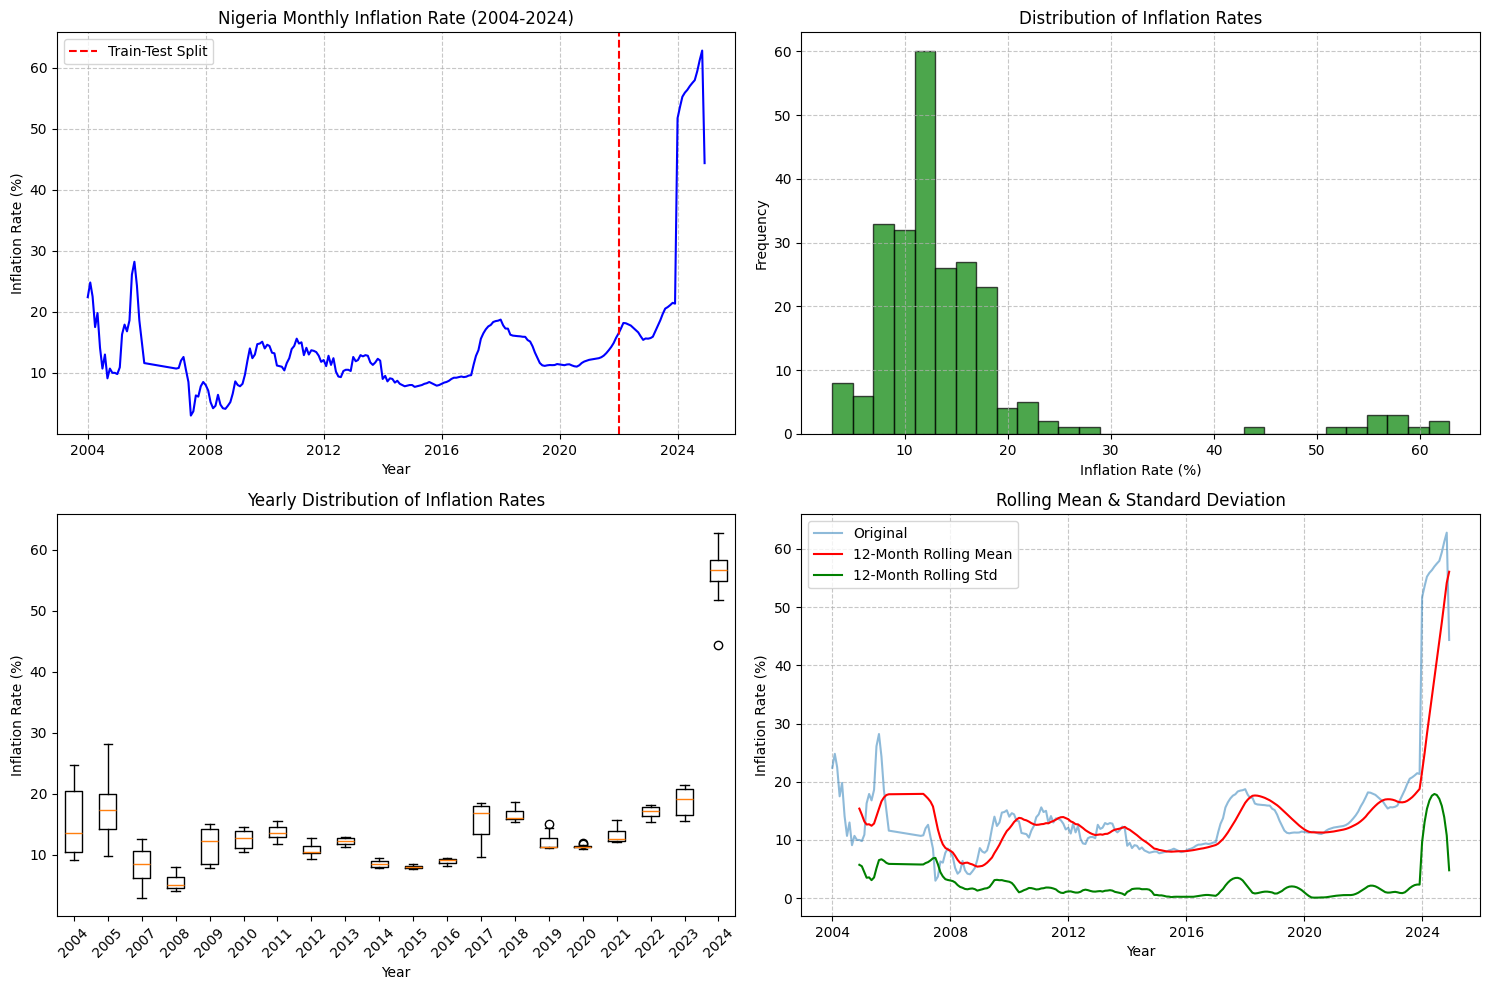

In [4]:
# Exploratory Data Analysis (same visualizations)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(inflation_data.index, inflation_data['Inflation_Rate'], linewidth=1.5, color='blue')
plt.axvline(x=pd.Timestamp('2022-01-01'), color='red', linestyle='--', label='Train-Test Split')
plt.title('Nigeria Monthly Inflation Rate (2004-2024)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(inflation_data['Inflation_Rate'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribution of Inflation Rates')
plt.xlabel('Inflation Rate (%)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 3)
inflation_data['Year'] = inflation_data.index.year
yearly_data = [group['Inflation_Rate'].values for name, group in inflation_data.groupby('Year')]
plt.boxplot(yearly_data, labels=inflation_data['Year'].unique())
plt.title('Yearly Distribution of Inflation Rates')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
rolling_mean = inflation_data['Inflation_Rate'].rolling(window=12).mean()
rolling_std = inflation_data['Inflation_Rate'].rolling(window=12).std()
plt.plot(inflation_data.index, inflation_data['Inflation_Rate'], label='Original', alpha=0.5)
plt.plot(inflation_data.index, rolling_mean, label='12-Month Rolling Mean', color='red')
plt.plot(inflation_data.index, rolling_std, label='12-Month Rolling Std', color='green')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('EDA_plots.png')
plt.show()

In [5]:
# Remove the Year column for modeling
inflation_data = inflation_data[['Inflation_Rate']]

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=12):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.window_size]
        y = self.data[idx + self.window_size]
        return torch.FloatTensor(x), torch.FloatTensor([y])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(inflation_data)

# Split data
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:len(scaled_data)]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 192
Testing data size: 48


In [6]:
# Create datasets and dataloaders
window_size = 12
batch_size = 32

train_dataset = TimeSeriesDataset(train_data.flatten(), window_size)
test_dataset = TimeSeriesDataset(test_data.flatten(), window_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 6
Testing batches: 2


In [7]:
# Define 1D-CNN Model
class CNN1DModel(nn.Module):
    def __init__(self, window_size):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

        # Calculate the size after convolutions and pooling
        conv_output_size = self._get_conv_output_size(window_size)

        self.fc1 = nn.Linear(conv_output_size, 50)
        self.fc2 = nn.Linear(50, 1)

    def _get_conv_output_size(self, window_size):
        # Mock forward pass to calculate size
        x = torch.zeros(1, 1, window_size)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        return x.numel()

    def forward(self, x):
        # x shape: (batch_size, window_size) -> (batch_size, 1, window_size) for Conv1d
        x = x.unsqueeze(1)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, window_size, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.window_size = window_size

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, window_size) -> (batch_size, window_size, 1) for LSTM
        x = x.unsqueeze(-1)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))

        # Use the last output
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [9]:
# Create models
cnn_model = CNN1DModel(window_size).to(device)
lstm_model = LSTMModel(window_size).to(device)

print("1D-CNN Model:")
print(cnn_model)
print("\nLSTM Model:")
print(lstm_model)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n1D-CNN Trainable parameters: {count_parameters(cnn_model):,}")
print(f"LSTM Trainable parameters: {count_parameters(lstm_model):,}")

1D-CNN Model:
CNN1DModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

LSTM Model:
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

1D-CNN Trainable parameters: 11,333
LSTM Trainable parameters: 31,051


In [10]:
# Define loss function and optimizers
criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, optimizer, criterion, num_epochs=100, model_name='Model'):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

    return train_losses

Training 1D-CNN model...
1D-CNN - Epoch [20/100], Loss: 0.004084
1D-CNN - Epoch [40/100], Loss: 0.002436
1D-CNN - Epoch [60/100], Loss: 0.002114
1D-CNN - Epoch [80/100], Loss: 0.001866
1D-CNN - Epoch [100/100], Loss: 0.001513

Training LSTM model...
LSTM - Epoch [20/100], Loss: 0.003817
LSTM - Epoch [40/100], Loss: 0.002286
LSTM - Epoch [60/100], Loss: 0.002096
LSTM - Epoch [80/100], Loss: 0.001817
LSTM - Epoch [100/100], Loss: 0.001455


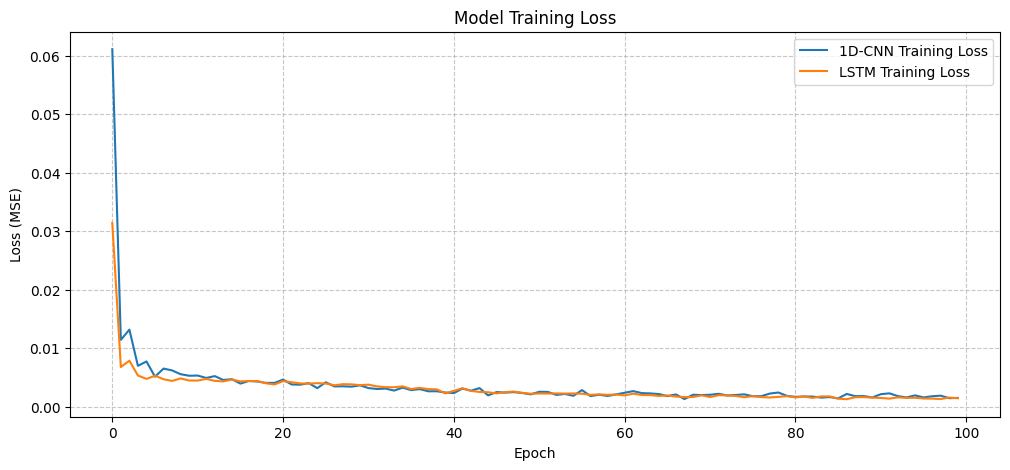

In [11]:
# Train both models
print("Training 1D-CNN model...")
cnn_losses = train_model(cnn_model, train_loader, cnn_optimizer, criterion, 100, '1D-CNN')

print("\nTraining LSTM model...")
lstm_losses = train_model(lstm_model, train_loader, lstm_optimizer, criterion, 100, 'LSTM')

# Plot training losses
plt.figure(figsize=(12, 5))
plt.plot(cnn_losses, label='1D-CNN Training Loss')
plt.plot(lstm_losses, label='LSTM Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Model Training Loss.png')
plt.show()

In [12]:
# Prediction function
def predict_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.numpy())

    return np.array(predictions), np.array(actuals)

# Make predictions
cnn_train_pred, cnn_train_actual = predict_model(cnn_model, train_loader)
cnn_test_pred, cnn_test_actual = predict_model(cnn_model, test_loader)

lstm_train_pred, lstm_train_actual = predict_model(lstm_model, train_loader)
lstm_test_pred, lstm_test_actual = predict_model(lstm_model, test_loader)

In [13]:
# Inverse transform predictions
def inverse_transform_predictions(predictions, actuals, scaler):
    # Reshape for inverse transform
    pred_2d = predictions.reshape(-1, 1)
    actual_2d = actuals.reshape(-1, 1)

    # Create dummy arrays for inverse transform
    pred_dummy = np.zeros((len(pred_2d), 1))
    actual_dummy = np.zeros((len(actual_2d), 1))

    pred_dummy[:, 0] = pred_2d[:, 0]
    actual_dummy[:, 0] = actual_2d[:, 0]

    # Inverse transform
    pred_inv = scaler.inverse_transform(pred_dummy)
    actual_inv = scaler.inverse_transform(actual_dummy)

    return pred_inv.flatten(), actual_inv.flatten()

# Inverse transform all predictions
cnn_train_pred_inv, cnn_train_actual_inv = inverse_transform_predictions(cnn_train_pred, cnn_train_actual, scaler)
cnn_test_pred_inv, cnn_test_actual_inv = inverse_transform_predictions(cnn_test_pred, cnn_test_actual, scaler)

lstm_train_pred_inv, lstm_train_actual_inv = inverse_transform_predictions(lstm_train_pred, lstm_train_actual, scaler)
lstm_test_pred_inv, lstm_test_actual_inv = inverse_transform_predictions(lstm_test_pred, lstm_test_actual, scaler)

In [14]:
# Calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse, rmse

# Calculate metrics
cnn_train_mse, cnn_train_rmse = calculate_metrics(cnn_train_actual_inv, cnn_train_pred_inv)
cnn_test_mse, cnn_test_rmse = calculate_metrics(cnn_test_actual_inv, cnn_test_pred_inv)

lstm_train_mse, lstm_train_rmse = calculate_metrics(lstm_train_actual_inv, lstm_train_pred_inv)
lstm_test_mse, lstm_test_rmse = calculate_metrics(lstm_test_actual_inv, lstm_test_pred_inv)

In [15]:
# Print results
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print("\nTRAINING SET PERFORMANCE:")
print(f"1D-CNN - MSE: {cnn_train_mse:.4f}, RMSE: {cnn_train_rmse:.4f}")
print(f"LSTM   - MSE: {lstm_train_mse:.4f}, RMSE: {lstm_train_rmse:.4f}")

print("\nTEST SET PERFORMANCE (2022-2024):")
print(f"1D-CNN - MSE: {cnn_test_mse:.4f}, RMSE: {cnn_test_rmse:.4f}")
print(f"LSTM   - MSE: {lstm_test_mse:.4f}, RMSE: {lstm_test_rmse:.4f}")

MODEL PERFORMANCE COMPARISON

TRAINING SET PERFORMANCE:
1D-CNN - MSE: 4.4933, RMSE: 2.1197
LSTM   - MSE: 4.0530, RMSE: 2.0132

TEST SET PERFORMANCE (2022-2024):
1D-CNN - MSE: 343.0706, RMSE: 18.5222
LSTM   - MSE: 104.1804, RMSE: 10.2069


In [16]:
# Determine best model
if cnn_test_rmse < lstm_test_rmse:
    best_model = "1D-CNN"
    best_rmse = cnn_test_rmse
else:
    best_model = "LSTM"
    best_rmse = lstm_test_rmse

print(f"\nBEST MODEL: {best_model} with Test RMSE: {best_rmse:.4f}")


BEST MODEL: LSTM with Test RMSE: 10.2069


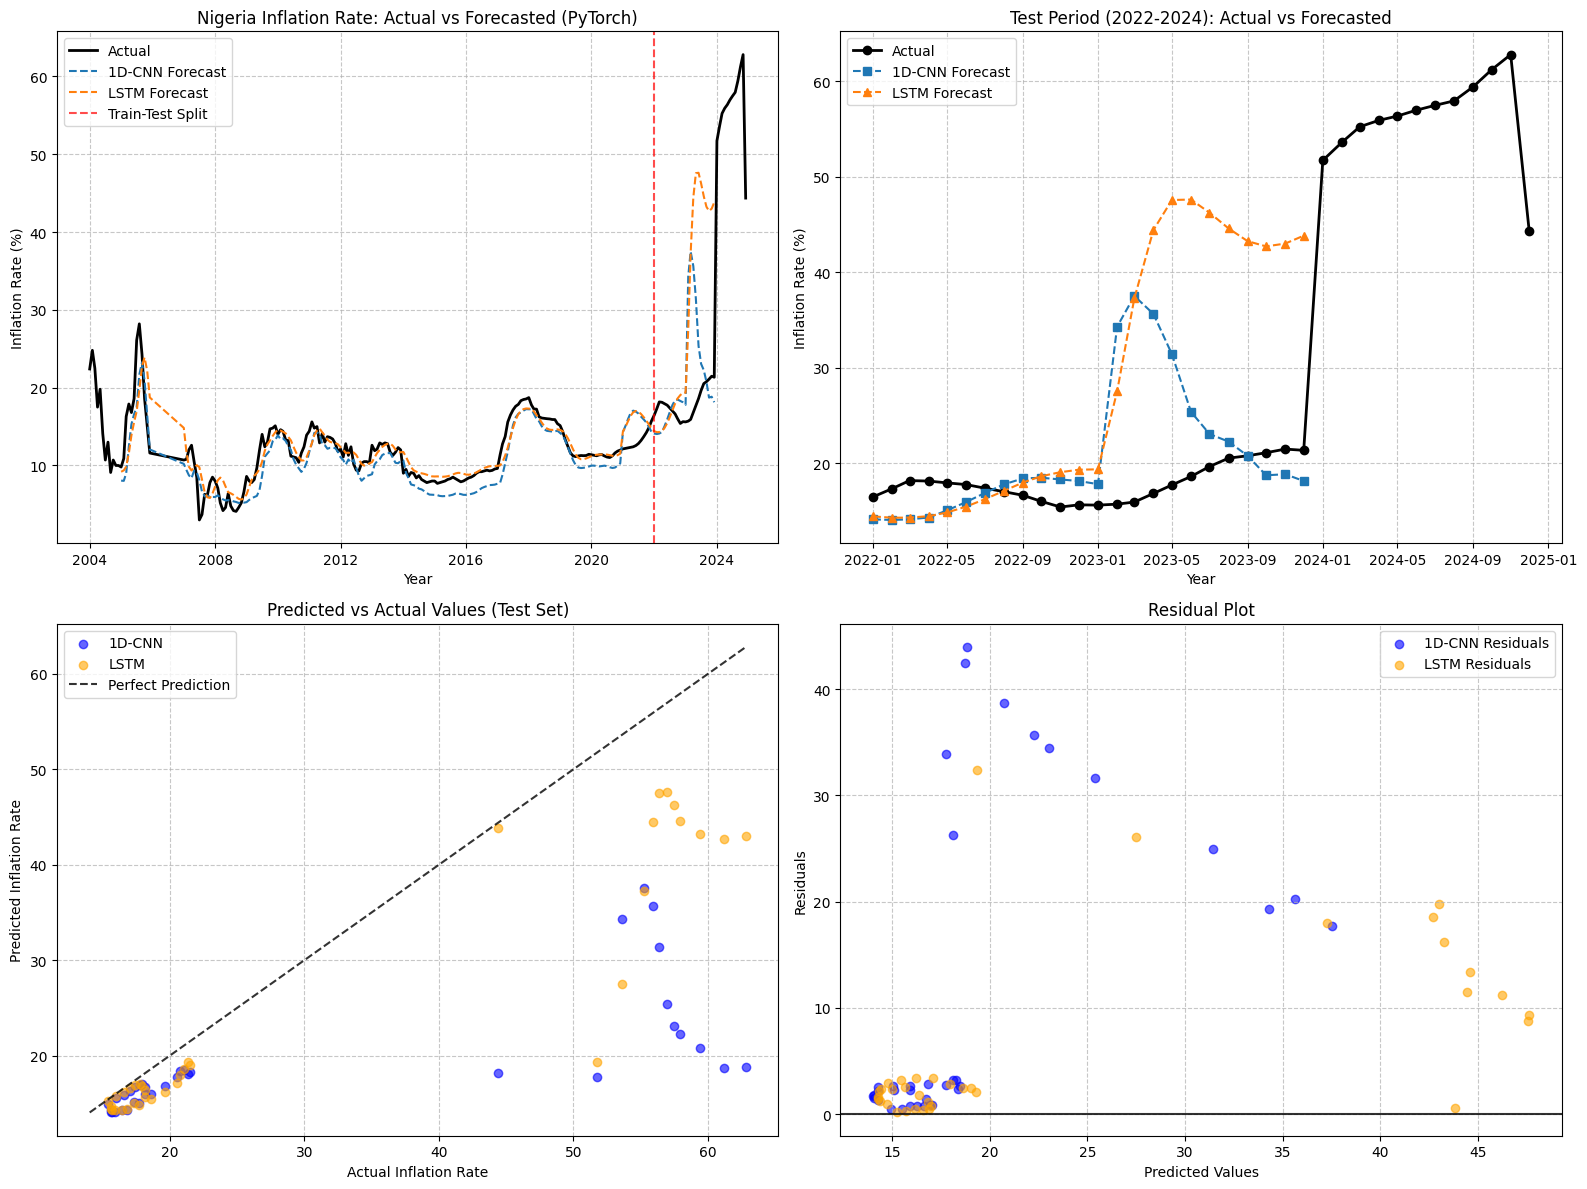

In [17]:
# Prepare results for visualization
def prepare_results_df(inflation_data, train_pred, test_pred, window_size):
    # Concatenate train and test predictions
    predictions = np.concatenate([train_pred, test_pred])

    # Create a DataFrame with the correct index and length
    results_df = pd.DataFrame(
        {'Predictions': predictions},
        index=inflation_data.index[window_size:window_size + len(predictions)] # Correct slicing for index
    )

    # Add the actual values for comparison
    results_df['Actual'] = inflation_data['Inflation_Rate'].iloc[window_size:window_size + len(predictions)].values

    return results_df

cnn_results_df = prepare_results_df(inflation_data, cnn_train_pred_inv, cnn_test_pred_inv, window_size)
lstm_results_df = prepare_results_df(inflation_data, lstm_train_pred_inv, lstm_test_pred_inv, window_size)


# Plot final results
plt.figure(figsize=(16, 12))

# Plot 1: Complete timeline with predictions
plt.subplot(2, 2, 1)
plt.plot(inflation_data.index, inflation_data['Inflation_Rate'], label='Actual', linewidth=2, color='black')
plt.plot(cnn_results_df.index, cnn_results_df['Predictions'], label='1D-CNN Forecast', linestyle='--', linewidth=1.5)
plt.plot(lstm_results_df.index, lstm_results_df['Predictions'], label='LSTM Forecast', linestyle='--', linewidth=1.5)
plt.axvline(x=pd.Timestamp('2022-01-01'), color='red', linestyle='--', alpha=0.7, label='Train-Test Split')
plt.title('Nigeria Inflation Rate: Actual vs Forecasted (PyTorch)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Zoom in on test period (2022-2024)
test_period_cnn = cnn_results_df[cnn_results_df.index >= '2022-01-01']
test_period_lstm = lstm_results_df[lstm_results_df.index >= '2022-01-01']
test_actual = inflation_data[inflation_data.index >= '2022-01-01']

plt.subplot(2, 2, 2)
plt.plot(test_actual.index, test_actual['Inflation_Rate'], label='Actual', linewidth=2, color='black', marker='o')
plt.plot(test_period_cnn.index, test_period_cnn['Predictions'], label='1D-CNN Forecast', linestyle='--', linewidth=1.5, marker='s')
plt.plot(test_period_lstm.index, test_period_lstm['Predictions'], label='LSTM Forecast', linestyle='--', linewidth=1.5, marker='^')
plt.title('Test Period (2022-2024): Actual vs Forecasted')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 3: Scatter plot of predictions vs actual
plt.subplot(2, 2, 3)
plt.scatter(cnn_test_actual_inv, cnn_test_pred_inv, alpha=0.6, label='1D-CNN', color='blue')
plt.scatter(lstm_test_actual_inv, lstm_test_pred_inv, alpha=0.6, label='LSTM', color='orange')
min_val = min(cnn_test_actual_inv.min(), cnn_test_pred_inv.min(), lstm_test_actual_inv.min(), lstm_test_pred_inv.min())
max_val = max(cnn_test_actual_inv.max(), cnn_test_pred_inv.max(), lstm_test_actual_inv.max(), lstm_test_pred_inv.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('Actual Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.title('Predicted vs Actual Values (Test Set)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 4: Residuals
plt.subplot(2, 2, 4)
cnn_residuals = cnn_test_actual_inv - cnn_test_pred_inv
lstm_residuals = lstm_test_actual_inv - lstm_test_pred_inv
plt.scatter(cnn_test_pred_inv, cnn_residuals, alpha=0.6, label='1D-CNN Residuals', color='blue')
plt.scatter(lstm_test_pred_inv, lstm_residuals, alpha=0.6, label='LSTM Residuals', color='orange')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.8)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('inflation_forecast_plots.png')
plt.show()

In [18]:
# Save models and results
torch.save(cnn_model.state_dict(), 'cnn_model.pth')
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

# Save results to CSV
# The length of the predictions is 216 (240 - 12 window size)
# We need to slice inflation_data to match this length
results_combined = pd.DataFrame({
    'Date': inflation_data.index[window_size:window_size + len(cnn_results_df['Predictions'].values)],
    'Actual': inflation_data['Inflation_Rate'].iloc[window_size:window_size + len(cnn_results_df['Predictions'].values)].values,
    'CNN_Predict': cnn_results_df['Predictions'].values,
    'LSTM_Predict': lstm_results_df['Predictions'].values
})
results_combined.to_csv('inflation_forecasting_results.csv', index=False)

In [19]:
# Additional: 12-month forecast function
def forecast_future(model, last_sequence, steps=12):
    """Forecast future values"""
    model.eval()
    future_predictions = []
    current_sequence = last_sequence.copy()

    with torch.no_grad():
        for _ in range(steps):
            # Prepare input
            input_seq = torch.FloatTensor(current_sequence).unsqueeze(0).to(device)

            # Predict next value
            pred = model(input_seq)
            next_value = pred.cpu().numpy()[0, 0]

            # Update sequence
            current_sequence = np.append(current_sequence[1:], next_value)
            future_predictions.append(next_value)

    # Inverse transform
    future_array = np.array(future_predictions).reshape(-1, 1)
    future_inv = scaler.inverse_transform(future_array)

    return future_inv.flatten()

# Get last sequence for forecasting
last_sequence = scaled_data[-window_size:].flatten()
cnn_future = forecast_future(cnn_model, last_sequence, 12)
lstm_future = forecast_future(lstm_model, last_sequence, 12)

print(f"\n12-Month Forecast (2025):")
print(f"1D-CNN: {cnn_future}")
print(f"LSTM: {lstm_future}")


12-Month Forecast (2025):
1D-CNN: [11.974769   7.7528896  6.6821     6.250512   5.4629703  5.168816
  5.383648   5.7460747  5.138925   4.022928   3.0580773  4.053751 ]
LSTM: [38.88698   32.103317  25.170002  18.89237   13.671555   9.646734
  6.742286   4.7570295  3.472786   2.7154446  2.3611658  2.323898 ]
